In [1]:
%load_ext autoreload
%autoreload 2

train_path = "../../../generateData/Eyedata/noisytrain"
test_path = "../../../generateData/Eyedata/noisytest"
val_path = "../../../generateData/Eyedata/noisyval"
maskTrain_path = "../../../generateData/data/maskTrain"
maskTest_path = "../../../generateData/data/maskTest"
maskVal_path = "../../../generateData/data/maskVal"


In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.smileyDataLoaderMoreEyes import LandmarksDataset, ToTensor, Rescale, ToTensorSeg1
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utilsSmileyMoreEyes import scipy_to_torch_sparse, genMatrixesLH

In [4]:
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale([320,256]),
                                             ToTensor()])
                                 )

# img_path = os.path.join(maskTest_path, 'Images')
# label_path = os.path.join(maskTest_path, 'landmarks')
masktest_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale([320,256]),
                                             ToTensorSeg1()])
                                 )

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from utils.smileyDataLoader import LandmarksDataset, ToTensor, Rescale


Total of landmarks: 15
Total of landmarks: 15


In [5]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
# Nodes 
N1 = A.shape[0]
N2 = AD.shape[0]

config = {}
config['n_nodes'] = [N1, N1, N1, N2, N2, N2]


A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = [320,256]

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 5
config['l2'] = 4

# double54 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device) # have not done this method yet
# # double54.load_state_dict(torch.load("../weights/Skip/double_L54/best.pt"))
# # double54.load_state_dict(torch.load("../Trainning/smiley50epocs/best.pt")) 
# double54.eval()
# print('Model loaded')

In [6]:
config['l1'] = 6
config['l2'] = 5
double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
# double65.load_state_dict(torch.load("../Training/noisyFaces500EpocsDoubleSkipNoAugEye/bestMSE_0.pt"))
double65.load_state_dict(torch.load("../Training/Synthh500EpocsDoubleSkipNoAugLayer65ValLoss/bestMSE_0.pt"))
double65.eval()
print('Model loaded')

[10, 8]
6-5
Model loaded


In [7]:
hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
# hybrid.load_state_dict(torch.load("../Training/smileyhybridbestworst50epochs/worstHD_0.pt"))
hybrid.load_state_dict(torch.load("../TrainingSave/Smiley24points/noisyFaces500EpocsHybridGNetNoAugEye/bestMSE_0.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [8]:
config['layer'] = 6

Skip6 = Skip(config, D_t, U_t, A_t).to(device)
Skip6.load_state_dict(torch.load("../TrainingSave/Smiley24points/noisyFaces500Epocs1SkipNoAugEye/bestMSE_0.pt"))
Skip6.eval()
print('Model loaded')

Model loaded


In [9]:
from models.unet import UNet

modelUNet = UNet(n_classes = 3).to(device)
#modelUNet.load_state_dict(torch.load('../Training/UnetWithnpy200epocsMasksPng1/bestDice_0.pt'))
modelUNet.load_state_dict(torch.load('../TrainingSave/Smiley24points/Unet500epochsnoisyWithMorePointsForEyes/bestDice_0.pt'))
modelUNet.eval()
print('Model loaded')

Model loaded


In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

model_list = [hybrid, Skip6, double65]
model_names = ['HybridGNet', '1-SC Layer 6', '2-SC Layers 6-5']


results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        print("data, target", data.shape, target.shape)

        data = torch.unsqueeze(data, 0).to(device)
        target =  target[:24,:].reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1)
            # Convert the list to a tensor
    # Convert the list to a numpy array
            scale = np.array([320, 256] * (len(target) // 2))

            # Scale the target and output
            scaled_target = target * scale
            scaled_output = output * scale

            # Calculate the mean squared error
            error = mean_squared_error(scaled_target, scaled_output)
            # Calculate the mean squared error
            # error = mean_squared_error(target * [320,256], output * [320,256])
            
            aux = pd.DataFrame([[i, error, model_names[j]]], columns=['i','MSE', 'Model'])
            results1 = results1.append(aux, ignore_index = True)

 1 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 2 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 3 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 4 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 5 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 6 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 7 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 8 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 9 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 10 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 11 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 12 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 13 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 14 of 15data, target torch.Size([1, 320, 256]) torch.Size([24, 2])
 15 of 15data, target torch.Size([1, 320, 256]) torch.Siz

MSE
HybridGNet 	563.609 +- 17.191
1-SC Layer 6 	550.010 +- 16.087
2-SC Layers 6-5 	545.353 +- 17.032



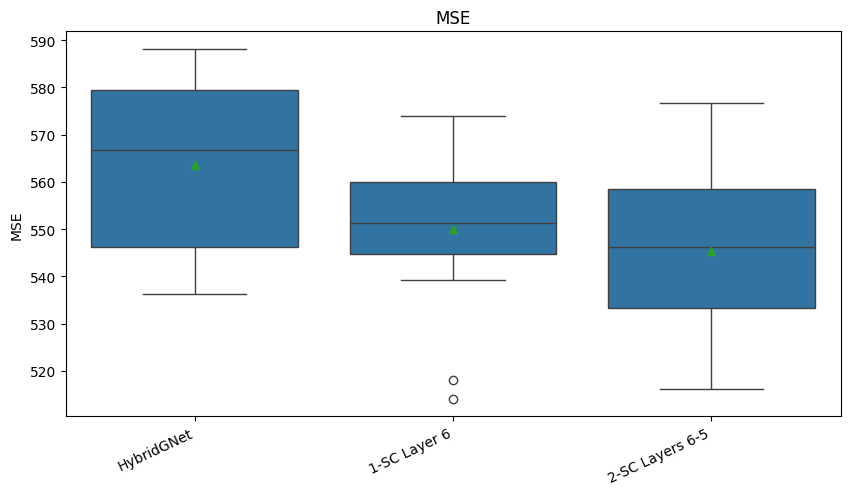

In [19]:
plt.figure(figsize = (10,5))
plt.tight_layout()
sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('MSE')
plt.title('MSE')
plt.xlabel(None)

print('MSE')
for model in model_names:
    print(model, '\t' '%.3f'%np.mean(results1['MSE'][results1['Model'] == model]), '+- %.3f' % np.std(results1['MSE'][results1['Model'] == model]))

print('')

In [17]:
model_names.append('UNet')

In [18]:
aux = results1[results1['Model'] == '2-SC Layers 6-5']
aux0 = aux.sort_values(by = 'MSE')[-3:]
aux0

,i,MSE,Model
35,11,880.678406,2-SC Layers 6-5
41,13,882.161316,2-SC Layers 6-5
17,5,900.864258,2-SC Layers 6-5


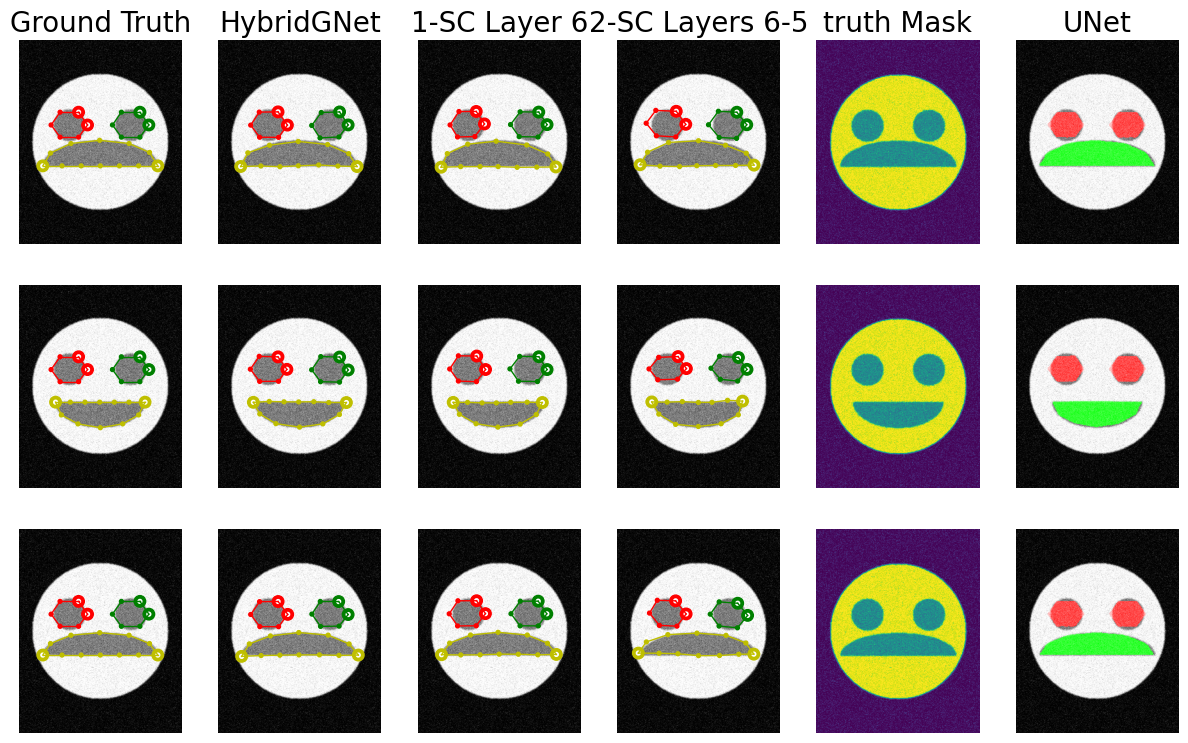

In [19]:
from utils.funSmileyMoreEyes import drawOrgans
from matplotlib import pyplot as plt


model_list_ = [hybrid, Skip6, double65]
model_names_ = ['HybridGNet', '1-SC Layer 6', '2-SC Layers 6-5']

i_ = [4,10,14]
#fig = plt.figure(figsize=(24, 8), dpi= 200)
fig = plt.figure(figsize=(3 * (len(model_list)+2), 9), dpi= 100)

fig.tight_layout()

c = 0
x = 320
y = 256
rows = len(i_)

for i in i_:

    with torch.no_grad():
        
        sample = test_dataset[i]
        cols = len(model_list_) + 3

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target = target.reshape(-1).numpy()
        

        masks_sample = masktest_dataset[i]
        mask_data, mask_target = masks_sample['image'], masks_sample['seg']
        mask_data = torch.unsqueeze(mask_data, 0).to(device)
        mask_target = mask_target.reshape(-1).numpy()

        draw = data.cpu().numpy()[0,0,:,:]
        
        ax = plt.subplot(rows, len(model_list_) + 3, 1 + c * (len(model_list_) + 3))
        plt.axis('off')
        plt.xlim(1, y)
        plt.ylim(x, 1)
        
        target = np.clip(target, 0, 1)
        target = target.reshape(-1, 2)

        if c == 0:
            drawOrgans(ax, target[:48]*x , None, draw.copy())
            plt.title("Ground Truth", fontsize = 20)            # For the first row
        else:
            drawOrgans(ax, target[:28] *x, None, draw.copy())

    
        for j in range(0, len(model_list_)):
            output = model_list_[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1) 
            output = np.clip(output, 0, 1)[:48]
            ax = plt.subplot(rows, len(model_list_) + 3, j + 2 + c * (len(model_list_) + 3))
            output = output.reshape(-1, 2)
            plt.axis('off')
            if c == 0:
                drawOrgans(ax, output * [x,y], None, draw.copy())
                plt.title(model_names_[j], fontsize = 20)
            else:
                drawOrgans(ax, output * [x,y], None, draw.copy())

            plt.xlim(1, y)
            plt.ylim(x, 1)
        
        ax = plt.subplot(rows, len(model_list_) + 3, 5 + c * (len(model_list_) + 3))
        if c == 0:
            plt.imshow(mask_data.cpu().numpy()[0,0,:,:])  # Convert tensor to numpy array and select the first channel of the image
            plt.title("truth Mask", fontsize = 20)  # For the first row
            plt.axis('off')
        else:
            plt.imshow(mask_data.cpu().numpy()[0,0,:,:])  # Convert tensor to numpy array and select the first channel of the image
            plt.axis('off')

        ax = plt.subplot(3, len(model_list_) + 3, j + 4 + c * (len(model_list_) + 3))

        plt.axis('off')

        output = modelUNet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        ax = plt.subplot(3, len(model_list_) + 3, j + 4 + c * (len(model_list_) + 3))
        ax = plt.subplot
        
        image=np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)
        if c == 0:
            plt.title('UNet', fontsize = 20)
        plt.imshow(image)
        plt.xlim(1, y)
        plt.ylim(x, 1)
        
        c += 1
        
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)      
# plt.savefig('figs/compare_UNet.png', bbox_inches = 'tight', dpi=200)
# plt.savefig('figs/compare_UNet.pdf', bbox_inches = 'tight', dpi=200)

In [17]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.funSmileyMoreEyes import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    output = output.cpu().numpy().reshape(-1) 
    p1, p2, h, c1, c2 = reverseVector(output)

    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    
    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest, target_heart)

    return [dcp, dcc, hdp, hdc]

def evalImageMetricsUNet(output, target_lungs, target_heart):
    dcp = dc(output == 1, target_lungs)
    dcc = dc(output == 2, target_heart)
    hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    hdc = hd(output == 2, target_heart, voxelspacing = 0.35)
        
    return [dcp, dcc, hdp, hdc]


In [18]:
blank = np.zeros([320, 256])
x = 320
y = 256
results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        p1, p2, h, c1, c2 = reverseVector(target * x)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)

        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            # output = output.cpu().numpy().reshape(-1) 
            output = output.reshape(-1, 2)
            scale = torch.tensor([x,y]).reshape(1,2).to(device)
            
            metrics = evalImageMetrics(blank, output * scale, t_lungs, t_heart)
             
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
            results = results.append(aux, ignore_index = True)
        
        out = modelUNet(data)[0,:,:,:]
        seg = torch.argmax(out, axis = 0).cpu().numpy()
        metrics = evalImageMetricsUNet(seg, t_lungs, t_heart)
        
        #aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Heart'])
        aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])

        results = results.append(aux, ignore_index = True)

 15 of 15

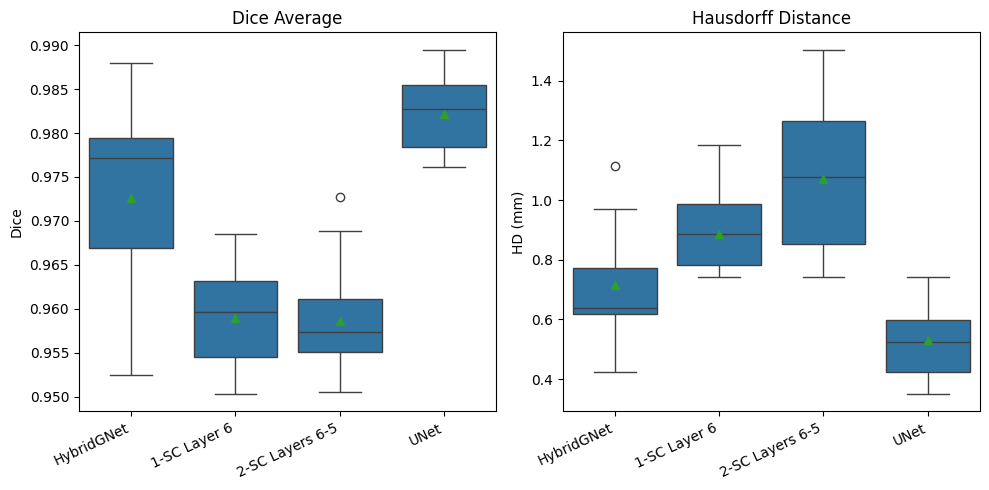

Dice
HybridGNet 0.973 +- 0.010
1-SC Layer 6 0.959 +- 0.006
2-SC Layers 6-5 0.959 +- 0.006
UNet 0.982 +- 0.004

Hausdorff
HybridGNet 0.714 +- 0.168
1-SC Layer 6 0.888 +- 0.130
2-SC Layers 6-5 1.070 +- 0.240
UNet 0.530 +- 0.119



In [19]:
import matplotlib.ticker as mticker

results['Dice Average'] = results[['Dice Lungs', 'Dice Heart']].mean(axis=1)
results['HD Average'] = results[['HD Lungs', 'HD Heart']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

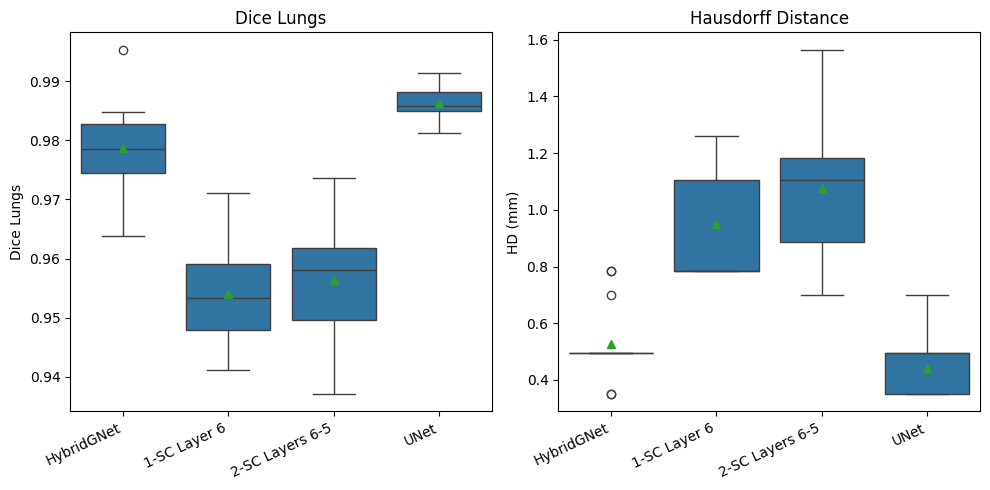

Dice
HybridGNet 0.979 +- 0.007
1-SC Layer 6 0.954 +- 0.008
2-SC Layers 6-5 0.956 +- 0.009
UNet 0.986 +- 0.003

Hausdorff
HybridGNet 0.528 +- 0.125
1-SC Layer 6 0.949 +- 0.195
2-SC Layers 6-5 1.077 +- 0.257
UNet 0.441 +- 0.098



In [20]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num2.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

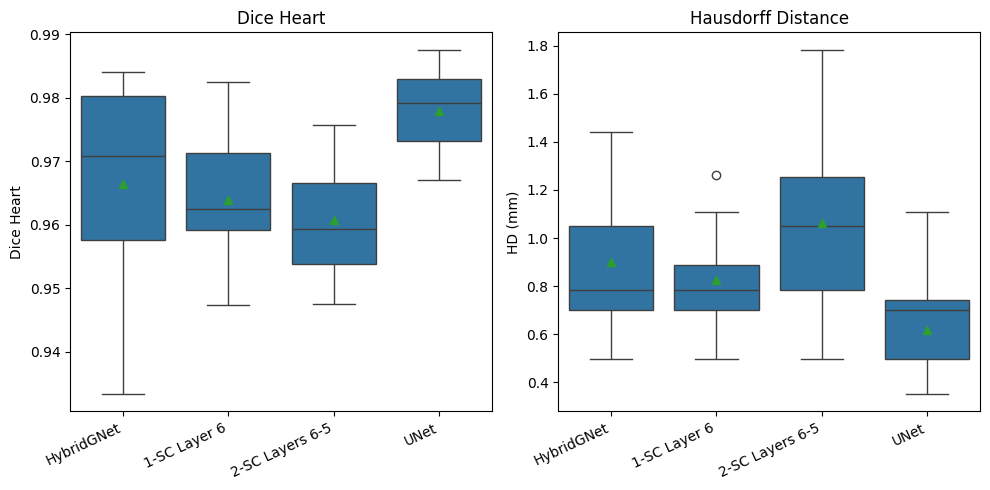

Dice
HybridGNet 0.966 +- 0.016
1-SC Layer 6 0.964 +- 0.009
2-SC Layers 6-5 0.961 +- 0.009
UNet 0.978 +- 0.006

Hausdorff
HybridGNet 0.901 +- 0.280
1-SC Layer 6 0.827 +- 0.188
2-SC Layers 6-5 1.063 +- 0.347
UNet 0.619 +- 0.204



In [21]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')

# Supplementary Results

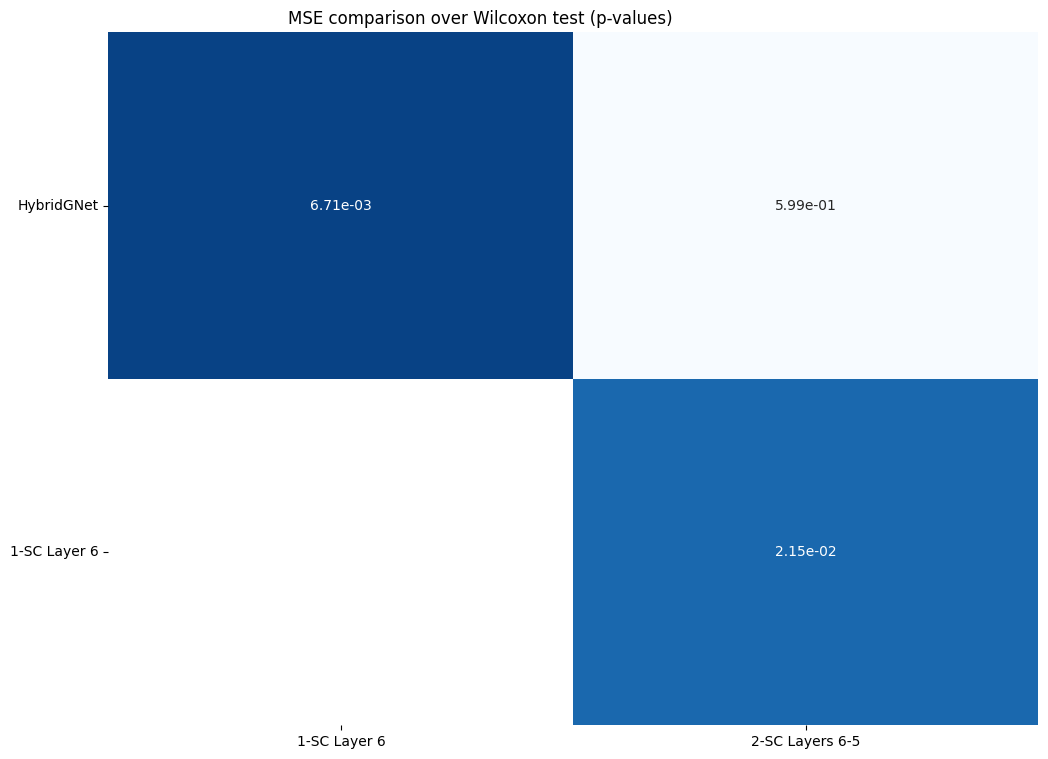

In [74]:
from scipy.stats import wilcoxon

model_names = ['HybridGNet','1-SC Layer 6', '2-SC Layers 6-5']

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results1[results1['Model'] == model1]['MSE']
        mse2 = results1[results1['Model'] == model2]['MSE']
        
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]
        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('MSE comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_MSE_wilcoxon.png', bbox_inches = 'tight')
plt.show()

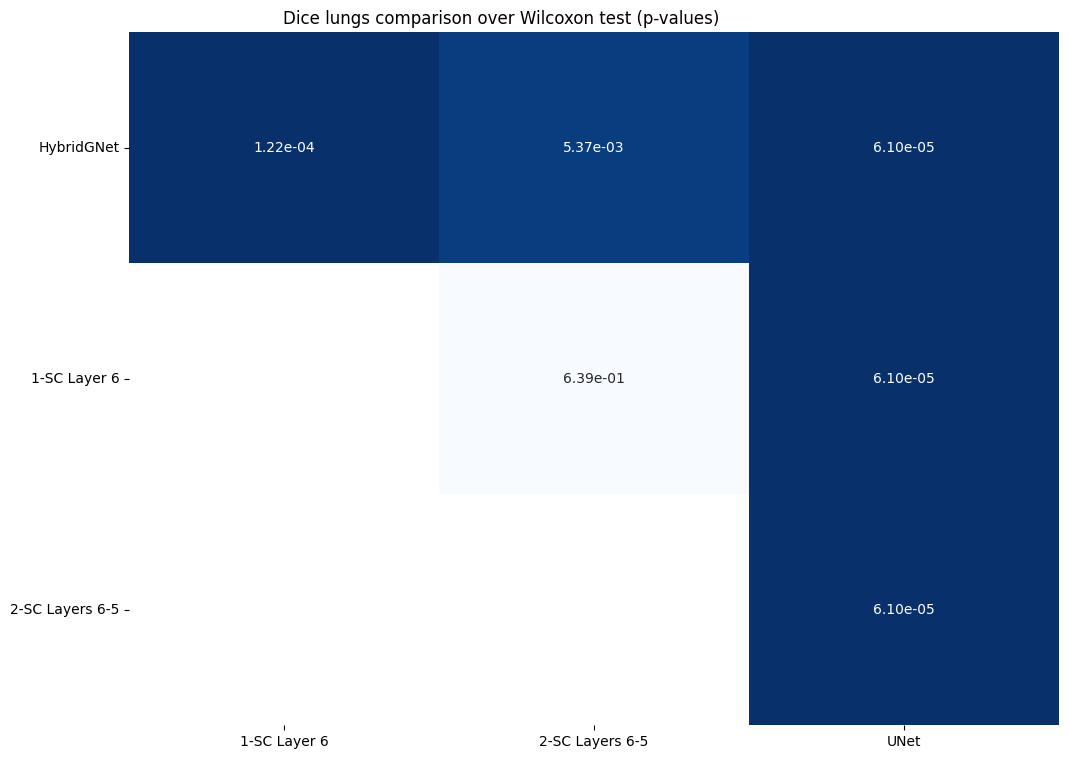

In [75]:
model_names.append('UNet')

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Lungs']
        mse2 = results[results['Model'] == model2]['Dice Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_dice_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

In [78]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Heart']
        mse2 = results[results['Model'] == model2]['Dice Heart']
        print(mse1, mse2)
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice heart comparison over Wilcoxon test (p-values)', x = 0.4)

# plt.savefig('figs/JSRT_dice_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

0     0.0
4     0.0
8     0.0
12    0.0
16    0.0
20    0.0
24    0.0
28    0.0
32    0.0
36    0.0
40    0.0
44    0.0
48    0.0
52    0.0
56    0.0
Name: Dice Heart, dtype: float64 1     0.0
5     0.0
9     0.0
13    0.0
17    0.0
21    0.0
25    0.0
29    0.0
33    0.0
37    0.0
41    0.0
45    0.0
49    0.0
53    0.0
57    0.0
Name: Dice Heart, dtype: float64


c:\Users\marie\miniforge3\envs\myenv\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

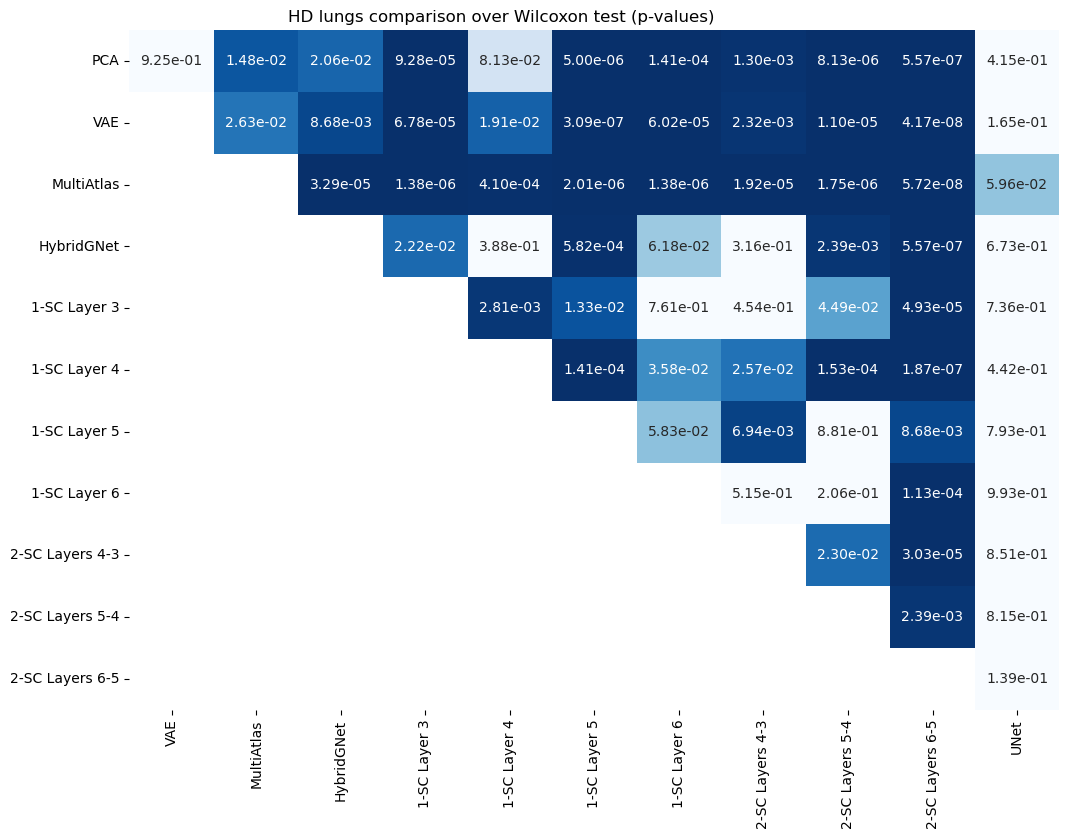

In [32]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Lungs']
        mse2 = results[results['Model'] == model2]['HD Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

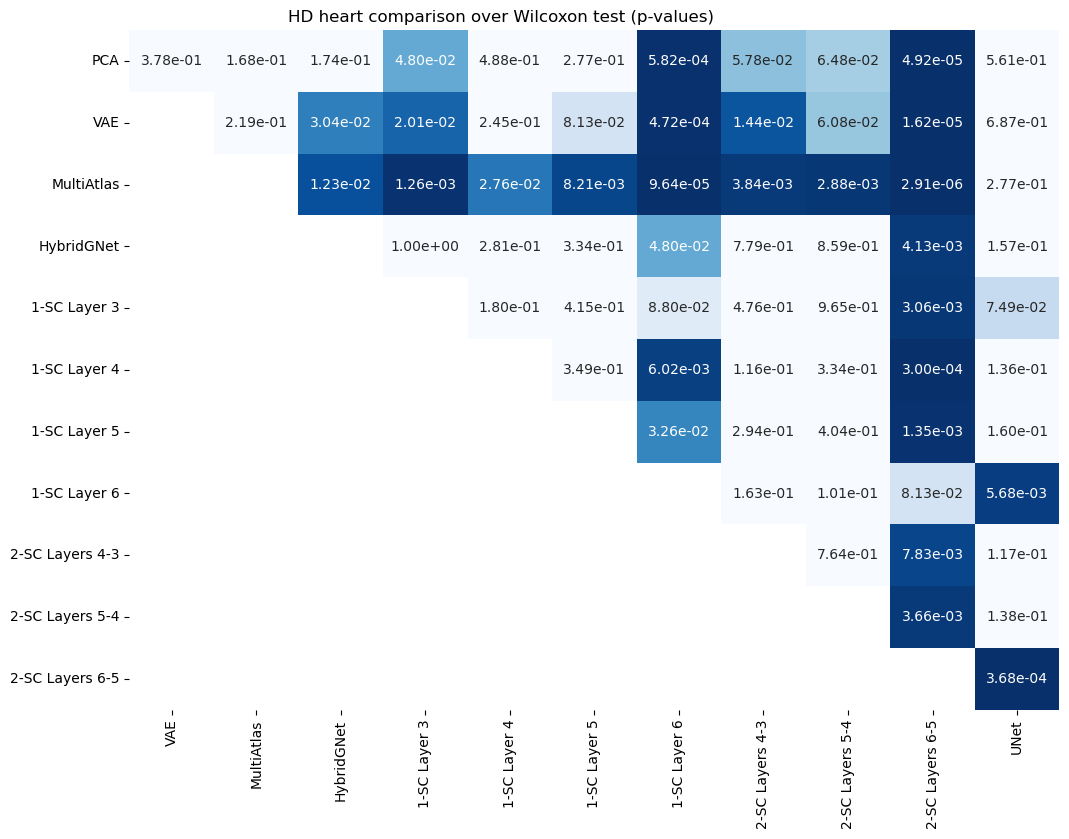

In [33]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Heart']
        mse2 = results[results['Model'] == model2]['HD Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD heart comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_heart.png', bbox_inches='tight')
plt.show()